In [1]:
!pip install tensorflow

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [3]:
import os
import pathlib

def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # Check if the foldpath is a directory
        if not os.path.isdir(foldpath):
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # Check if there are nested directories
            if os.path.isdir(fpath):
                # Ignore 'masks' directories
                if os.path.basename(fpath).lower() == 'masks':
                    continue

                # Process files within nested directories
                for nested_file in os.listdir(fpath):
                    ipath = os.path.join(fpath, nested_file)
                    filepaths.append(ipath)
                    labels.append(fold)
            else:
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def split_data(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    
    # Split into training and remaining (dummy) sets
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
    
    # Further split the dummy set into validation and test sets
    strat_dummy = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat_dummy)

    return train_df, valid_df, test_df

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [6]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras

class MyCallback(keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience  # Epochs without improvement before adjusting learning rate
        self.stop_patience = stop_patience  # Number of times to adjust lr without improvement before stopping training
        self.threshold = threshold  # Training accuracy threshold for lr adjustment based on validation loss
        self.factor = factor  # Factor to reduce learning rate
        self.batches = batches  # Number of training batches per epoch
        self.epochs = epochs  # Total number of epochs
        self.ask_epoch = ask_epoch  # Epoch at which to ask user for input
        self.ask_epoch_initial = ask_epoch  # Save initial value to restore if restarting training

        # Callback variables
        self.count = 0  # Counter for epochs without improvement
        self.stop_count = 0  # Counter for learning rate adjustments
        self.best_epoch = 1  # Epoch with the lowest loss
        self.highest_tracc = 0.0  # Highest training accuracy
        self.lowest_vloss = np.inf  # Lowest validation loss
        self.best_weights = None  # Best model weights
        self.initial_lr = None  # Initial learning rate
        self.initial_weights = None  # Initial model weights

    def on_train_begin(self, logs=None):
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))  # Initial learning rate
        self.initial_weights = self.model.get_weights()  # Save initial weights
        print('Do you want the model to ask you to halt the training [y/n]?')
        ans = input('').strip().lower()
        self.ask_permission = 1 if ans in ['y', 'yes'] else 0

        header = '{:^8s}{:^10s}{:^9s}{:^9s}{:^9s}{:^9s}{:^9s}{:^10s}{:^10s}{:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(header)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours, remainder = divmod(tr_duration, 3600)
        minutes, seconds = divmod(remainder, 60)

        print(f'Training elapsed time was {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds')
        self.model.set_weights(self.best_weights)  # Set the model weights to the best weights

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        print(f'Processing batch {batch + 1} of {self.batches} - accuracy: {acc:.3f} - loss: {loss:.5f}', end='\r')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc if epoch > 0 else 0.0

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.lowest_vloss = min(self.lowest_vloss, v_loss)
                self.best_epoch = epoch + 1
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                    self.count = 0
                    self.stop_count += 1
        else:
            monitor = 'val_loss'
            pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss if epoch > 0 else 0.0

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                    self.count = 0
                    self.stop_count += 1
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{epoch + 1:^3}/{self.epochs:^4} {loss:^9.3f} {acc * 100:^9.3f} {v_loss:^9.5f} {v_acc * 100:^9.3f} {lr:^9.5f} {monitor:^11} {pimprov:^10.2f} {duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            print(f'Training halted at epoch {epoch + 1} after {self.stop_patience} learning rate adjustments with no improvement')
            self.model.stop_training = True
        elif self.ask_epoch is not None and self.ask_permission:
            if epoch + 1 >= self.ask_epoch:
                print('Enter H to halt training or an integer for the number of epochs to run before asking again')
                ans = input('').strip().lower()
                if ans in ['h']:
                    print(f'Training halted at epoch {epoch + 1} due to user input')
                    self.model.stop_training = True
                else:
                    try:
                        self.ask_epoch += int(ans)
                        print(f'Training will continue until epoch {self.ask_epoch}')
                        header = '{:^8s}{:^10s}{:^9s}{:^9s}{:^9s}{:^9s}{:^9s}{:^10s}{:^10s}{:^8s}'.format(
                            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                        print(header)
                    except ValueError:
                        print('Invalid input, continuing training without user intervention')


In [7]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [9]:
data_dir = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)
    
    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print(f'Invalid Input: {e}')

Found 16932 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.


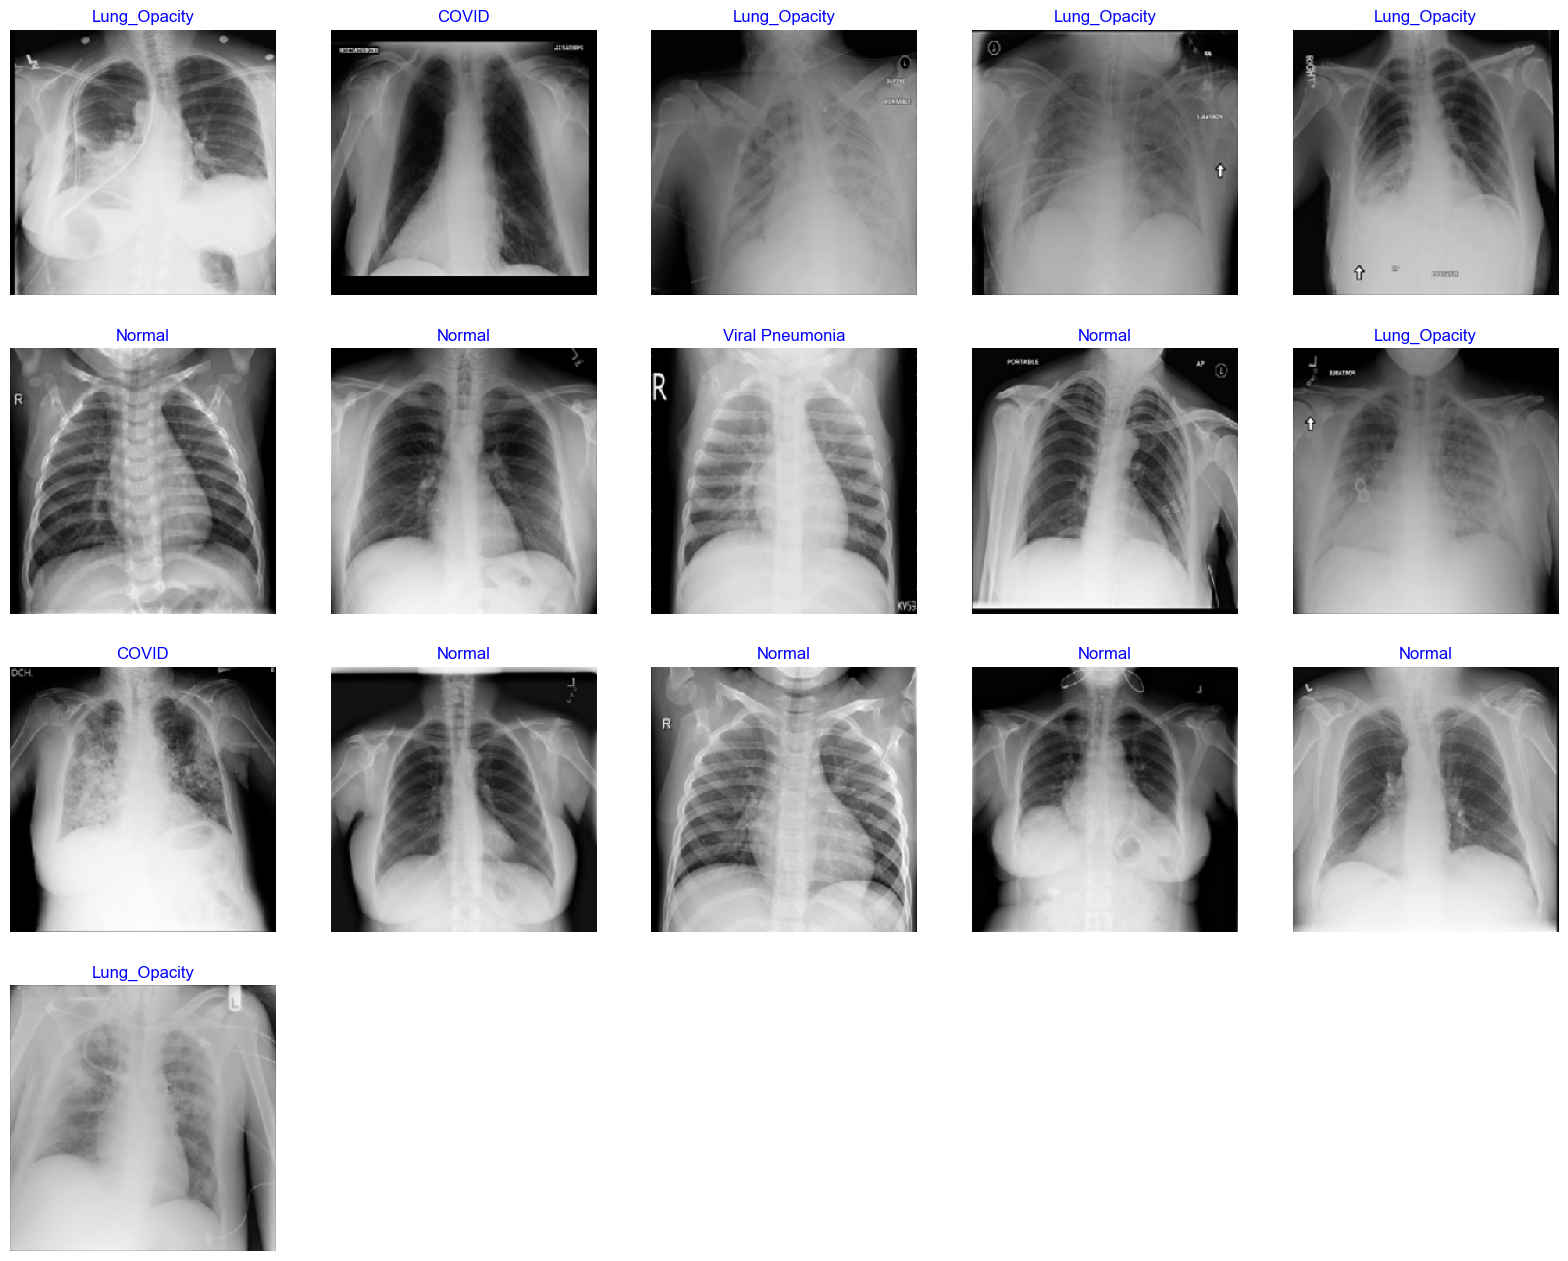

In [10]:
show_images(train_gen)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Ensure input shape
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Running the model once to ensure it is built
dummy_input = tf.zeros((1, *img_shape))  # Create a dummy input
model(dummy_input)  # Run model once with dummy input

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (1, 1280)              │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 1280)              │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 256)               │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 4)                 │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 4,339,072 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [12]:
# Example usage
batch_size = 16
epochs = 20
patience = 3
stop_patience = 10
threshold = 0.9
factor = 0.5
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want the model to ask you to halt the training [y/n]?


 n


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor   % Improv Duration
 1 / 20    5.052    52.799    2.62544   53.755    0.00100   accuracy      0.00     830.52 
 2 / 20    1.789    52.729    1.37119   54.511    0.00100   accuracy     -0.13     817.23 
 3 / 20    1.231    59.314    1.06170   69.957    0.00100   accuracy     12.34     792.11 
 4 / 20    1.089    64.109    0.97538   71.564    0.00100   accuracy      8.09     801.49 
 5 / 20    1.033    65.604    0.95591   70.997    0.00100   accuracy      2.33     821.59 
 6 / 20    0.962    71.882    0.81557   83.325    0.00100   accuracy      9.57     785.42 
 7 / 20    0.813    80.239    0.63824   88.285    0.00100   accuracy     11.63     767.67 
 8 / 20    0.714    84.261    0.49846   95.040    0.00100   accuracy      5.01     764.73 
 9 / 20    0.655    85.885    0.48107   94.143    0.00100   accuracy      1.93     798.54 
10 / 20    0.607    87.621    0.45899   94.143    0.00100   accuracy      2.02     825.79

In [13]:
# 保存模型到文件
model.save('/Users/fangshiyuan/Desktop/UCL/毕设-1/EfficientNetB0_model.h5')

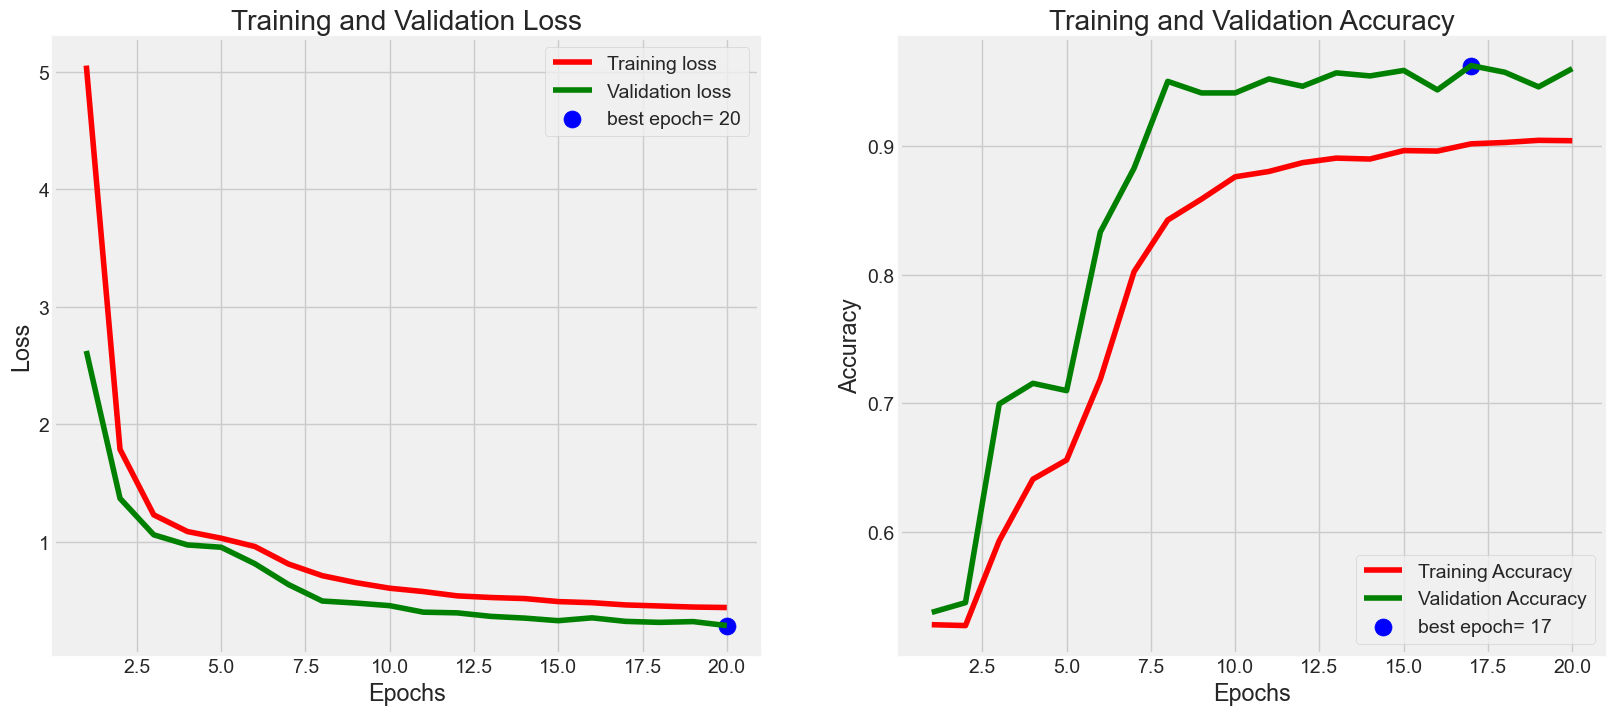

In [14]:
plot_training(history)

In [15]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9921 - loss: 0.2258
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9628 - loss: 0.2877
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 506ms/step - accuracy: 0.9559 - loss: 0.7272
Train Loss:  0.22929643094539642
Train Accuracy:  0.9892241358757019
--------------------
Validation Loss:  0.295769602060318
Validation Accuracy:  0.9633620977401733
--------------------
Test Loss:  0.7256484031677246
Test Accuracy:  0.9536861777305603


In [16]:
# 假设 test_gen 已经定义并准备好使用
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 538ms/step
[1 1 1 ... 2 2 2]


Confusion Matrix, Without Normalization
[[358   0   3   0]
 [  4 547  50   0]
 [  3  34 982   1]
 [  1   0   2 131]]
                 precision    recall  f1-score   support

          COVID       0.98      0.99      0.98       361
   Lung_Opacity       0.94      0.91      0.93       601
         Normal       0.95      0.96      0.95      1020
Viral Pneumonia       0.99      0.98      0.98       134

       accuracy                           0.95      2116
      macro avg       0.96      0.96      0.96      2116
   weighted avg       0.95      0.95      0.95      2116



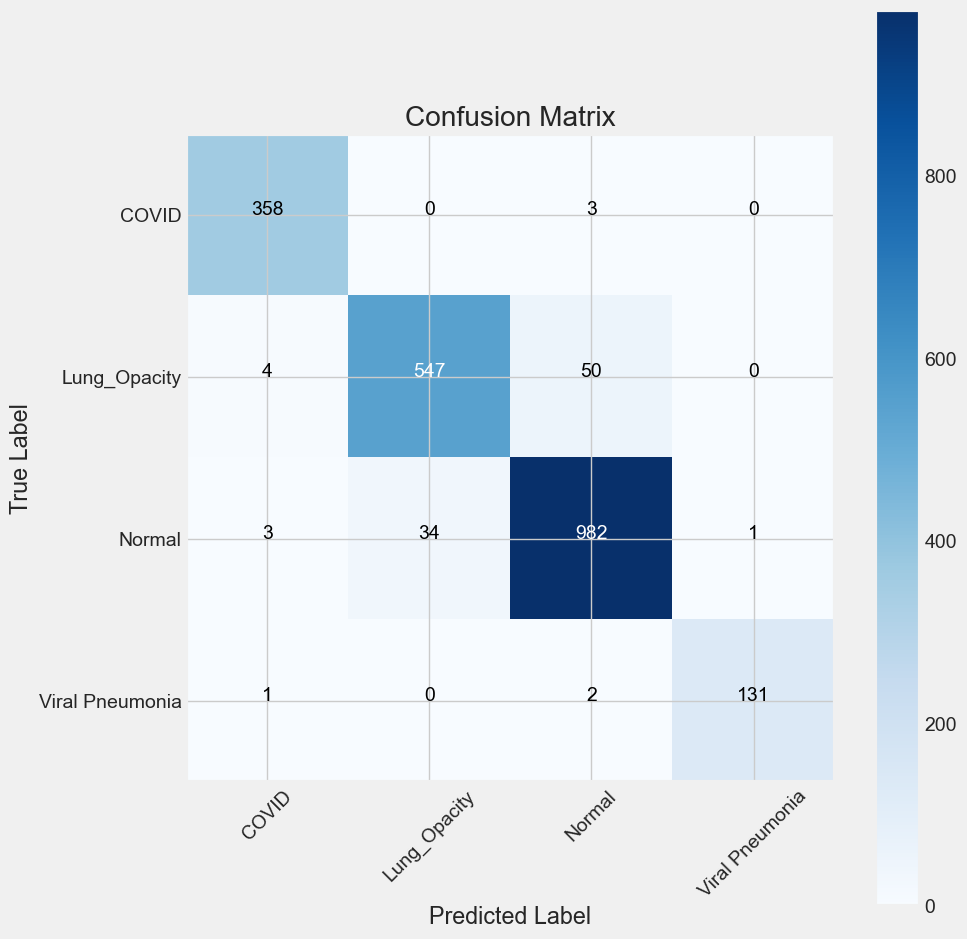

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

使用Saliency Maps显著性图————可解释

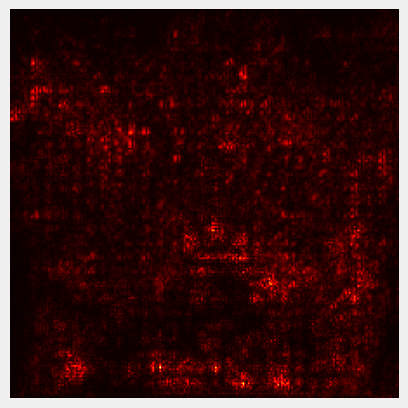

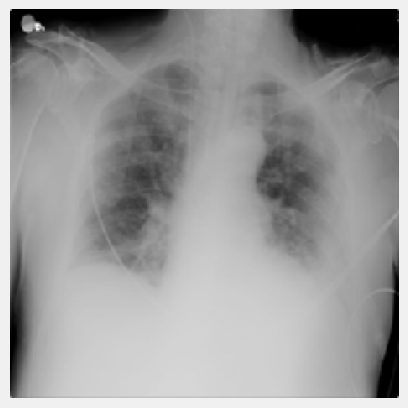

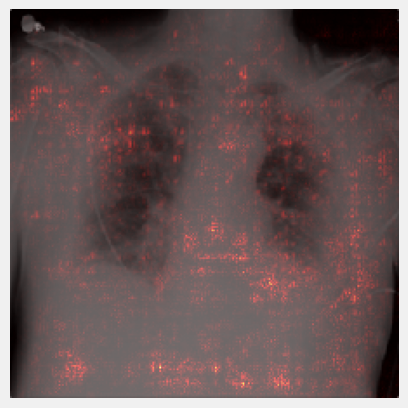

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img = image.load_img(img_path, target_size=(224, 224))  # 将图像大小调整为 (224, 224)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # 根据模型预处理函数调整

# 将 numpy 数组转换为 TensorFlow 张量
img_array = tf.convert_to_tensor(img_array)

# 计算梯度
with tf.GradientTape() as tape:
    tape.watch(img_array)
    preds = model(img_array)
    top_pred_idx = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_idx]

# 获取图像相对于预测类别的梯度
grads = tape.gradient(top_class_channel, img_array)

# 取绝对值并沿通道轴取最大值，生成Saliency Map
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

# 可视化Saliency Map
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.show()

# 将Saliency Map与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(saliency, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.show()

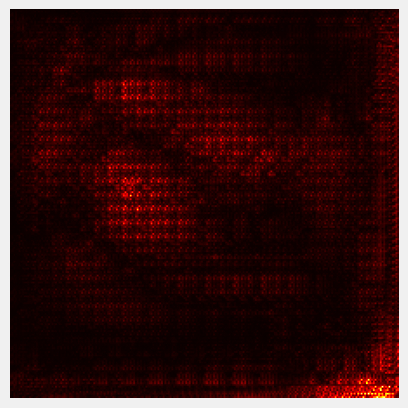

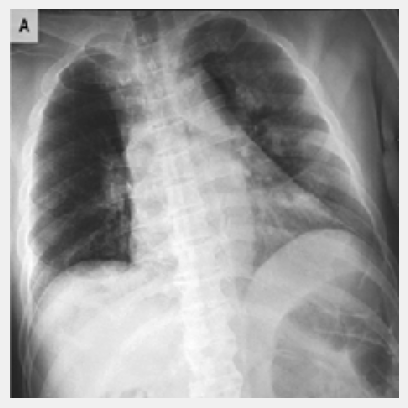

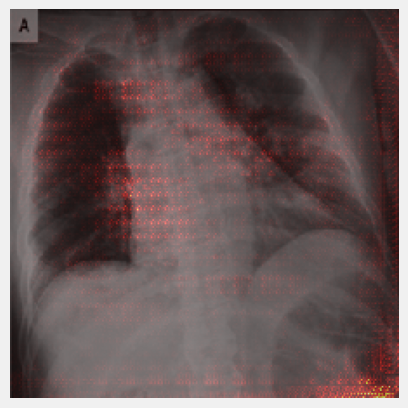

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-2.png'
img = image.load_img(img_path, target_size=(224, 224))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 将 numpy 数组转换为 TensorFlow 张量
img_array = tf.convert_to_tensor(img_array)

# 计算梯度
with tf.GradientTape() as tape:
    tape.watch(img_array)
    preds = model(img_array)
    top_pred_idx = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_idx]

# 获取图像相对于预测类别的梯度
grads = tape.gradient(top_class_channel, img_array)

# 取绝对值并沿通道轴取最大值，生成Saliency Map
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

# 可视化Saliency Map
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.show()

# 将Saliency Map与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(saliency, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.show()

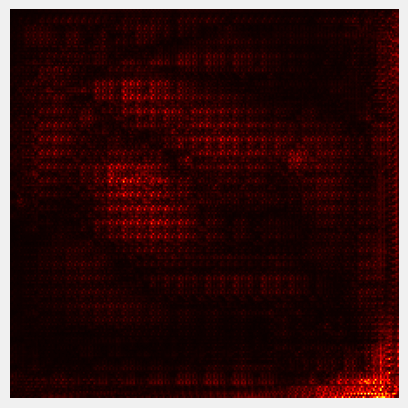

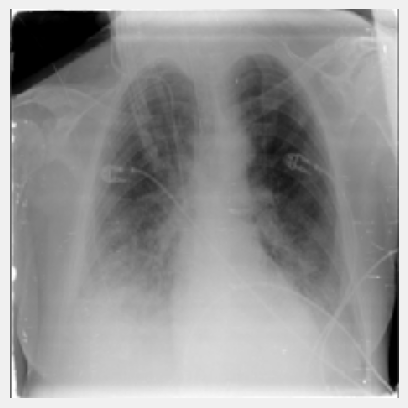

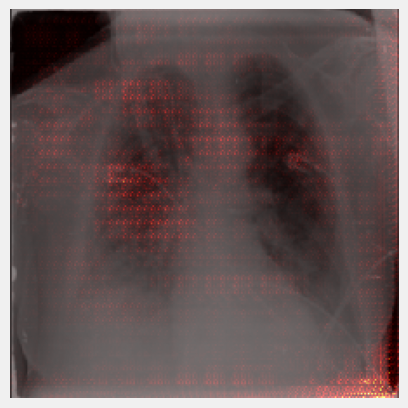

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-3.png'
img = image.load_img(img_path, target_size=(224, 224))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 将 numpy 数组转换为 TensorFlow 张量
img_array = tf.convert_to_tensor(img_array)

# 计算梯度
with tf.GradientTape() as tape:
    tape.watch(img_array)
    preds = model(img_array)
    top_pred_idx = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_idx]

# 获取图像相对于预测类别的梯度
grads = tape.gradient(top_class_channel, img_array)

# 取绝对值并沿通道轴取最大值，生成Saliency Map
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

# 可视化Saliency Map
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.show()

# 将Saliency Map与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(saliency, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.show()

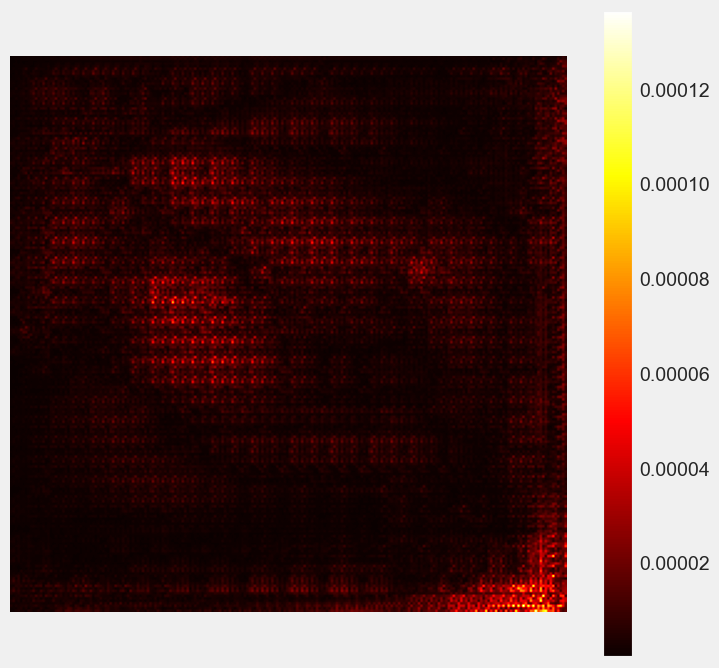

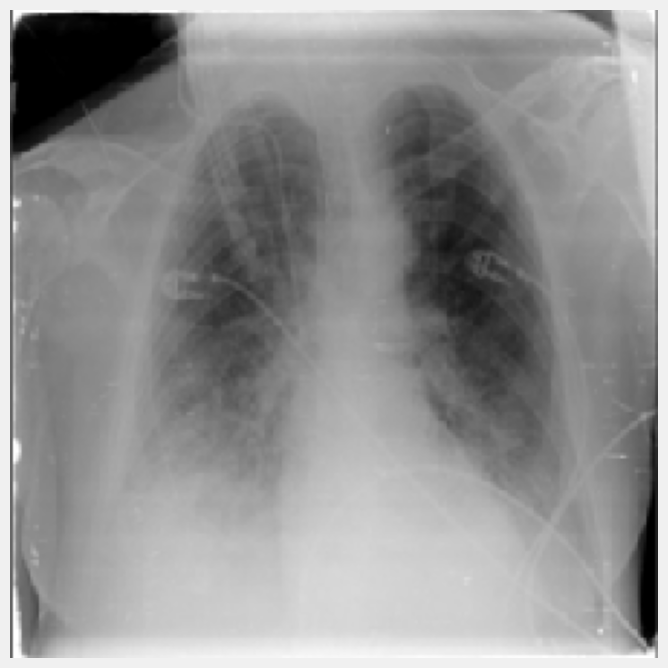

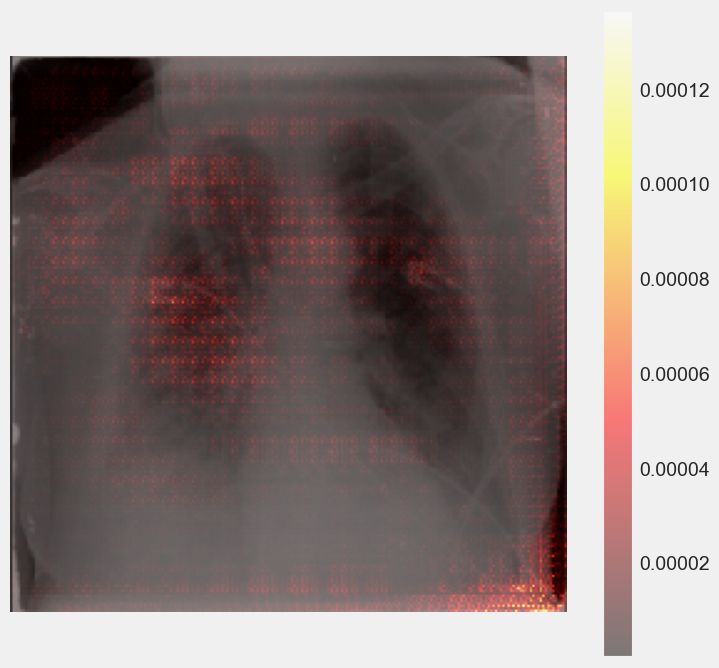

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-3.png'
img = image.load_img(img_path, target_size=(224, 224))  # 将图像大小调整为 (224, 224)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 将 numpy 数组转换为 TensorFlow 张量
img_array = tf.convert_to_tensor(img_array)

# 计算梯度
with tf.GradientTape() as tape:
    tape.watch(img_array)
    preds = model(img_array)
    top_pred_idx = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_idx]

# 获取图像相对于预测类别的梯度
grads = tape.gradient(top_class_channel, img_array)

# 取绝对值并沿通道轴取最大值，生成Saliency Map
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

# 可视化Saliency Map并添加热力图颜色条
plt.figure(figsize=(8, 8))
plt.imshow(saliency, cmap='hot')
plt.colorbar()  # 添加颜色条
plt.axis('off')
plt.show()

# 显示原始图像
plt.figure(figsize=(8, 8))
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.show()

# 将Saliency Map与原图叠加显示，并添加热力图颜色条
plt.figure(figsize=(8, 8))
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(saliency, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.colorbar()  # 添加颜色条
plt.axis('off')
plt.show()

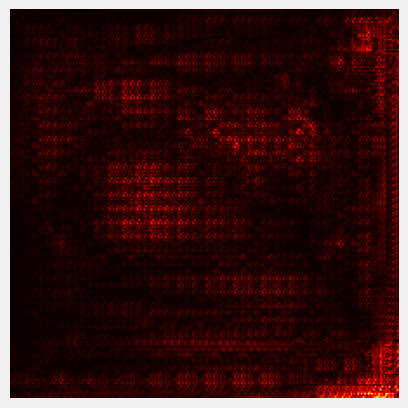

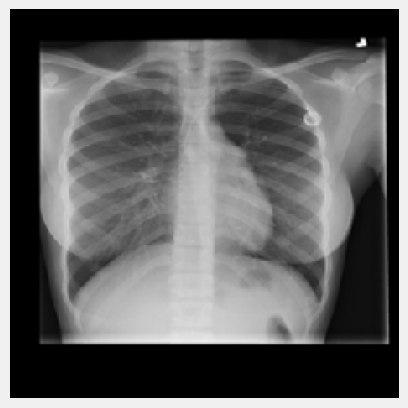

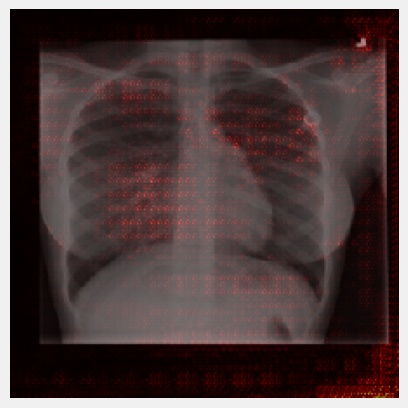

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png'
img = image.load_img(img_path, target_size=(224, 224))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 将 numpy 数组转换为 TensorFlow 张量
img_array = tf.convert_to_tensor(img_array)

# 计算梯度
with tf.GradientTape() as tape:
    tape.watch(img_array)
    preds = model(img_array)
    top_pred_idx = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_idx]

# 获取图像相对于预测类别的梯度
grads = tape.gradient(top_class_channel, img_array)

# 取绝对值并沿通道轴取最大值，生成Saliency Map
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

# 可视化Saliency Map
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.show()

# 将Saliency Map与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(saliency, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.show()

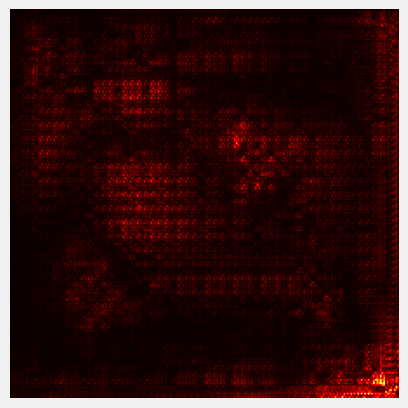

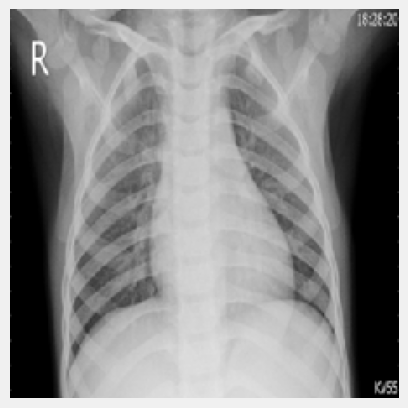

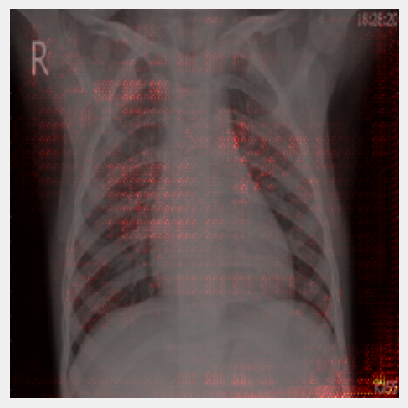

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-2.png'
img = image.load_img(img_path, target_size=(224, 224))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 将 numpy 数组转换为 TensorFlow 张量
img_array = tf.convert_to_tensor(img_array)

# 计算梯度
with tf.GradientTape() as tape:
    tape.watch(img_array)
    preds = model(img_array)
    top_pred_idx = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_idx]

# 获取图像相对于预测类别的梯度
grads = tape.gradient(top_class_channel, img_array)

# 取绝对值并沿通道轴取最大值，生成Saliency Map
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

# 可视化Saliency Map
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.show()

# 将Saliency Map与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(saliency, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.show()

Occlusion Sensitivity 遮挡敏感性

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

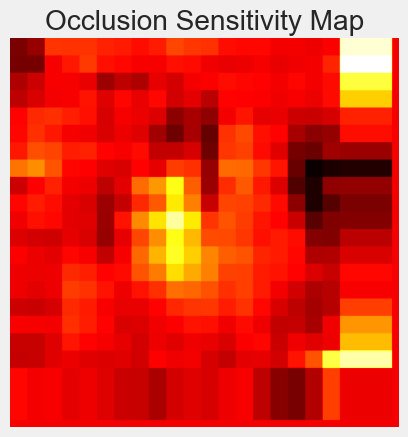

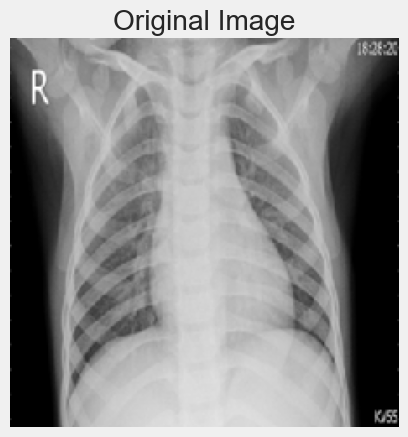

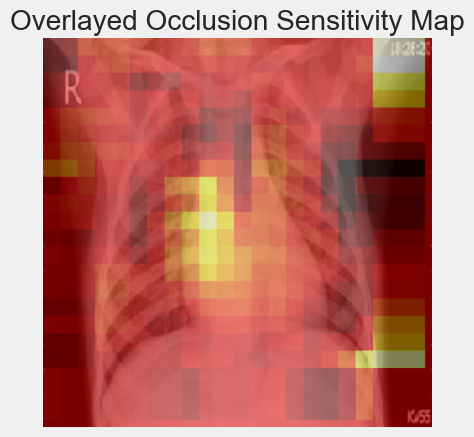

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-2.png'
img = image.load_img(img_path, target_size=(224, 224))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 设置遮挡块的大小和步长
occlusion_size = 30  # 遮挡块的大小
occlusion_stride = 10  # 遮挡块的步长
occlusion_value = 0  # 使用黑色遮挡块

# 获取原始预测类别
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])

# 初始化敏感性图
sensitivity_map = np.zeros((img_array.shape[1], img_array.shape[2]))

# 遍历图像，应用遮挡块
for i in range(0, img_array.shape[1] - occlusion_size, occlusion_stride):
    for j in range(0, img_array.shape[2] - occlusion_size, occlusion_stride):
        # 创建一个副本用于遮挡
        occluded_img_array = img_array.copy()
        occluded_img_array[:, i:i+occlusion_size, j:j+occlusion_size, :] = occlusion_value
        
        # 获取遮挡图像的预测结果
        occluded_preds = model.predict(occluded_img_array)
        occluded_class_score = occluded_preds[0][predicted_class]
        
        # 计算预测分数的变化并记录
        sensitivity_map[i:i+occlusion_size, j:j+occlusion_size] = preds[0][predicted_class] - occluded_class_score

# 标准化敏感性图
sensitivity_map = (sensitivity_map - np.min(sensitivity_map)) / (np.max(sensitivity_map) - np.min(sensitivity_map))

# 可视化敏感性图
plt.imshow(sensitivity_map, cmap='hot')
plt.axis('off')
plt.title('Occlusion Sensitivity Map')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.title('Original Image')
plt.show()

# 将敏感性图与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(sensitivity_map, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.title('Overlayed Occlusion Sensitivity Map')
plt.show()

更小的像素值

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 设置更精细的遮挡块大小和步长
occlusion_size = 10  # 更小的遮挡块大小，例如 10x10 像素
occlusion_stride = 5  # 更小的步长，例如 5 像素
occlusion_value = 0  # 使用黑色遮挡块

# 获取原始预测类别
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])

# 初始化敏感性图
sensitivity_map = np.zeros((img_array.shape[1], img_array.shape[2]))

# 遍历图像，应用遮挡块
for i in range(0, img_array.shape[1] - occlusion_size, occlusion_stride):
    for j in range(0, img_array.shape[2] - occlusion_size, occlusion_stride):
        # 创建一个副本用于遮挡
        occluded_img_array = img_array.copy()
        occluded_img_array[:, i:i+occlusion_size, j:j+occlusion_size, :] = occlusion_value
        
        # 获取遮挡图像的预测结果
        occluded_preds = model.predict(occluded_img_array)
        occluded_class_score = occluded_preds[0][predicted_class]
        
        # 计算预测分数的变化并记录
        sensitivity_map[i:i+occlusion_size, j:j+occlusion_size] = preds[0][predicted_class] - occluded_class_score

# 标准化敏感性图
sensitivity_map = (sensitivity_map - np.min(sensitivity_map)) / (np.max(sensitivity_map) - np.min(sensitivity_map))

# 可视化敏感性图
plt.imshow(sensitivity_map, cmap='hot')
plt.axis('off')
plt.title('Occlusion Sensitivity Map')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.title('Original Image')
plt.show()

# 将敏感性图与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(sensitivity_map, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.title('Overlayed Occlusion Sensitivity Map')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 设置遮挡块的大小和步长
occlusion_size = 30  # 遮挡块的大小
occlusion_stride = 10  # 遮挡块的步长
occlusion_value = 0  # 使用黑色遮挡块

# 获取原始预测类别
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])

# 初始化敏感性图
sensitivity_map = np.zeros((img_array.shape[1], img_array.shape[2]))

# 遍历图像，应用遮挡块
for i in range(0, img_array.shape[1] - occlusion_size, occlusion_stride):
    for j in range(0, img_array.shape[2] - occlusion_size, occlusion_stride):
        # 创建一个副本用于遮挡
        occluded_img_array = img_array.copy()
        occluded_img_array[:, i:i+occlusion_size, j:j+occlusion_size, :] = occlusion_value
        
        # 获取遮挡图像的预测结果
        occluded_preds = model.predict(occluded_img_array)
        occluded_class_score = occluded_preds[0][predicted_class]
        
        # 计算预测分数的变化并记录
        sensitivity_map[i:i+occlusion_size, j:j+occlusion_size] = preds[0][predicted_class] - occluded_class_score

# 标准化敏感性图
sensitivity_map = (sensitivity_map - np.min(sensitivity_map)) / (np.max(sensitivity_map) - np.min(sensitivity_map))

# 可视化敏感性图
plt.imshow(sensitivity_map, cmap='hot')
plt.axis('off')
plt.title('Occlusion Sensitivity Map')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.title('Original Image')
plt.show()

# 将敏感性图与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(sensitivity_map, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.title('Overlayed Occlusion Sensitivity Map')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png'
img = image.load_img(img_path, target_size=(299, 299))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 设置遮挡块的大小和步长
occlusion_size = 30  # 遮挡块的大小
occlusion_stride = 10  # 遮挡块的步长
occlusion_value = 0  # 使用黑色遮挡块

# 获取原始预测类别
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])

# 初始化敏感性图
sensitivity_map = np.zeros((img_array.shape[1], img_array.shape[2]))

# 遍历图像，应用遮挡块
for i in range(0, img_array.shape[1] - occlusion_size, occlusion_stride):
    for j in range(0, img_array.shape[2] - occlusion_size, occlusion_stride):
        # 创建一个副本用于遮挡
        occluded_img_array = img_array.copy()
        occluded_img_array[:, i:i+occlusion_size, j:j+occlusion_size, :] = occlusion_value
        
        # 获取遮挡图像的预测结果
        occluded_preds = model.predict(occluded_img_array)
        occluded_class_score = occluded_preds[0][predicted_class]
        
        # 计算预测分数的变化并记录
        sensitivity_map[i:i+occlusion_size, j:j+occlusion_size] = preds[0][predicted_class] - occluded_class_score

# 标准化敏感性图
sensitivity_map = (sensitivity_map - np.min(sensitivity_map)) / (np.max(sensitivity_map) - np.min(sensitivity_map))

# 可视化敏感性图
plt.imshow(sensitivity_map, cmap='hot')
plt.axis('off')
plt.title('Occlusion Sensitivity Map')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.title('Original Image')
plt.show()

# 将敏感性图与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(sensitivity_map, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.title('Overlayed Occlusion Sensitivity Map')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 假设之前已经定义并编译好了 model，并且该 model 已经训练好

# 加载并预处理图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png'
img = image.load_img(img_path, target_size=(299, 299))  # 将图像大小调整为 (299, 299)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 根据模型预处理函数调整

# 设置遮挡块的大小和步长
occlusion_size = 30  # 遮挡块的大小
occlusion_stride = 10  # 遮挡块的步长
occlusion_value = 0  # 使用黑色遮挡块

# 获取原始预测类别
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])

# 初始化敏感性图
sensitivity_map = np.zeros((img_array.shape[1], img_array.shape[2]))

# 遍历图像，应用遮挡块
for i in range(0, img_array.shape[1] - occlusion_size, occlusion_stride):
    for j in range(0, img_array.shape[2] - occlusion_size, occlusion_stride):
        # 创建一个副本用于遮挡
        occluded_img_array = img_array.copy()
        occluded_img_array[:, i:i+occlusion_size, j:j+occlusion_size, :] = occlusion_value
        
        # 获取遮挡图像的预测结果
        occluded_preds = model.predict(occluded_img_array)
        occluded_class_score = occluded_preds[0][predicted_class]
        
        # 计算预测分数的变化并记录
        sensitivity_map[i:i+occlusion_size, j:j+occlusion_size] = preds[0][predicted_class] - occluded_class_score

# 标准化敏感性图
sensitivity_map = (sensitivity_map - np.min(sensitivity_map)) / (np.max(sensitivity_map) - np.min(sensitivity_map))

# 可视化敏感性图
plt.imshow(sensitivity_map, cmap='hot')
plt.axis('off')
plt.title('Occlusion Sensitivity Map')
plt.show()

# 显示原始图像
plt.imshow(image.array_to_img(img_array[0]))
plt.axis('off')
plt.title('Original Image')
plt.show()

# 将敏感性图与原图叠加显示
plt.imshow(image.array_to_img(img_array[0]))
plt.imshow(sensitivity_map, cmap='hot', alpha=0.5)  # alpha控制叠加的透明度
plt.axis('off')
plt.title('Overlayed Occlusion Sensitivity Map')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-3.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (1, 1280)              │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 1280)              │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 256)               │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 4)                 │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,061,801 (49.83 MB)

 Trainable params: 4,339,072 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

 Optimizer params: 8,678,146 (33.10 MB)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "efficientnetb0" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 299, 299, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 299, 299, 3), dtype=float32)
  • training=None
  • mask=None

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-4.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-5.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/COVID/images/COVID-6.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-3.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-4.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-5.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-6.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-7.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-8.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-9.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = '/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Normal/images/Normal-10.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = r'/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = r'/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-2.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = r'/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-3.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = r'/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-4.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = r'/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-5.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 打印模型架构
model.summary()

# 用虚拟输入调用一次模型，确保模型被初始化
dummy_input = tf.zeros((1, 299, 299, 3))  # 使用适合 Xception 模型的输入形状
dummy_output = model(dummy_input)

# 打印模型的输出
print(dummy_output)

# 加载图像
img_path = r'/Users/fangshiyuan/Desktop/UCL/毕设-1/COVID-19_Code/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-6.png'
img = image.load_img(img_path, target_size=(299, 299))  # 调整图像尺寸为 (299, 299)

# 预处理图像
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # 使用适合 Xception 的预处理方法

# 定义 make_gradcam_heatmap 函数
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 获取最后一个卷积层
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(f"Last conv layer output: {last_conv_layer.output}")  # 打印最后一个卷积层的输出
    
    # 构建新的模型，该模型的输出是最后一个卷积层和最终的输出
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(f"Last conv layer output shape: {last_conv_layer_output.shape}")  # 打印最后一个卷积层的输出形状
        print(f"Model predictions: {preds}")  # 打印模型预测
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(f"Gradients shape: {grads.shape}")  # 打印梯度形状
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # 生成热力图
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 使用正确的卷积层名称计算 Grad-CAM 热力图
last_conv_layer_name = 'block14_sepconv2_act'  # 假设这是 Xception 模型的最后一个卷积层名称
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# 定义保存和显示 Grad-CAM 的函数
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # 确保热力图是 uint8 类型
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * alpha + img)  # 确保叠加后的图像是 uint8 类型
    cv2.imwrite(cam_path, superimposed_img)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 保存并显示 Grad-CAM
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = [
    'Healthy', 
    'COVID-19', 
    'Viral Pneumonia', 
    'Lung Opacity'
]

# Sample distribution counts
sizes = [
    10192, # Healthy
    3616,  # COVID-19
    1345,  # Viral Pneumonia
    6012   # Lung Opacity
]

# Colors for each segment
colors = [
    '#ff9999','#66b3ff','#99ff99','#ffcc99'
]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, startangle=90, counterclock=False, wedgeprops=dict(width=0.3, edgecolor='w'))

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Adjust title to prevent overlapping
plt.title('CXR images distribution for each infection type in the dataset', pad=20)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# 定义数据源和类别
data = {
    'COVID-19': ['Padchest Dataset', 'Germany Medical School', 'SIRM, Github, Kaggle & Twitter', 'Other Github Sources'],
    'Normal': ['RSNA Dataset', 'Kaggle Dataset'],
    'Lung Opacity': ['RSNA Dataset'],
    'Viral Pneumonia': ['Chest X-Ray Images (Pneumonia)']
}

# 创建图
G = nx.DiGraph()

# 添加节点和边
for category, sources in data.items():
    G.add_node(category, color='lightcoral')
    for source in sources:
        G.add_node(source, color='lightblue')
        G.add_edge(category, source)

# 设置节点颜色
colors = [G.nodes[node]['color'] for node in G]

# 绘制图形
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=3000, font_size=10, font_weight='bold', edge_color='gray')
plt.title("Data Sources Hierarchy", fontsize=15)
plt.show()